# 北京 PM2.5 数据预测（未完成）

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

数据来源：http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data


In [2]:
data_path = 'PRSA_data_2010.1.1-2014.12.31.csv'
rides = pd.read_csv(data_path)
# rides.dropna() 
rides.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


## 数据简介

该小时数据集包含了 2010 年 1 月 1 日至 2014 年 12 月 31 日美国驻北京大使馆 PM2.5 数据与北京首都国际机场气象资料。缺少的数据用 Na 替代。

下图是数据集前 10 天的 PM2.5（第一天无数据）

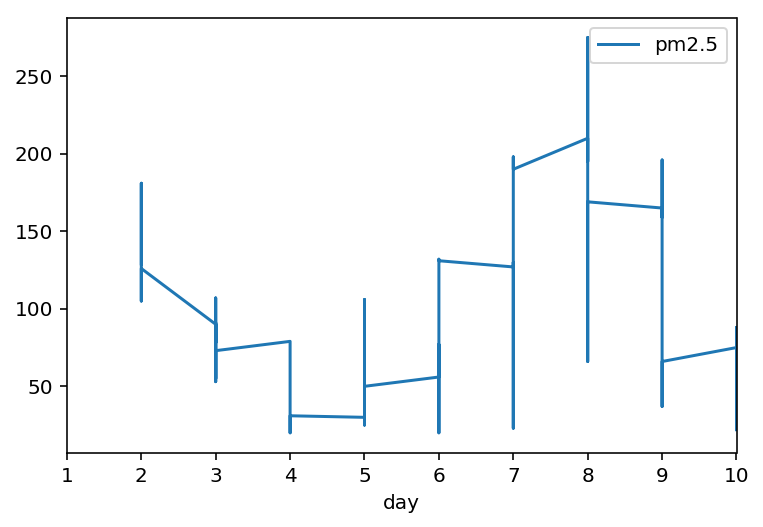

In [3]:
rides[:24*10].plot(x='day', y='pm2.5')

## 虚拟变量
下面是分类变量，例如风向。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 get_dummies() 就可以轻松实现。

In [4]:
dummy_fields = ['cbwd']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
fields_to_drop = ['cbwd']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


## 调整目标变量
为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [5]:
quant_features = ['pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

## 将数据拆分为训练、测试和验证数据集
我们将大约最后 31 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的 PM2.5 数据进行对比。

In [6]:
# Save data for approximately the last 21 days 
test_data = data[-31*24:]

# Now remove the test data from the data set 
data = data[:-31*24]

# Separate the data into features and targets
target_fields = ['pm2.5']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [7]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 构建网络

In [ ]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        self.activation_function = lambda x : 1 / (1 + np.exp(-x))                
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###
            
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            hidden_error = np.dot(self.weights_hidden_to_output,error)
            
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 训练网络

In [ ]:
import sys

### Set the hyperparameters here ###
iterations = 1000
learning_rate = 0.5
hidden_nodes = 5
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['pm2.5']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['pm2.5'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['pm2.5'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果
使用测试数据看看网络对数据建模的效果如何。

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['pm2.5']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['pm2.5']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['day'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)